In [6]:
import mmcv
import matplotlib.pyplot as plt

In [7]:
# Choose to use a config and initialize the detector
config = '/home/aiteam/tykim/scratch/lightweight/mmdet_nano/Picodet_Pytorch/configs/picodet/picodet_l_640_coco.py'
# Load the config
cfg = mmcv.Config.fromfile(config)

In [8]:
# config 수정하기
from mmdet.apis import set_random_seed

# Dataset
cfg.dataset_type = 'COCODataset'
cfg.data_root = '/home/aiteam/tykim/scratch/lightweight/mmcv_phone/hold_smartphone'

cfg.data.train.ann_file = '/home/aiteam/tykim/scratch/lightweight/mmcv_phone/hold_smartphone/annos/train.json'
cfg.data.train.img_prefix = '/home/aiteam/tykim/scratch/lightweight/mmcv_phone/hold_smartphone/imgs'
cfg.data.train.classes = ('smartphone',)

cfg.data.val.ann_file = '/home/aiteam/tykim/scratch/lightweight/mmcv_phone/hold_smartphone/annos/val.json'
cfg.data.val.img_prefix = '/home/aiteam/tykim/scratch/lightweight/mmcv_phone/hold_smartphone/imgs'
cfg.data.val.classes = ('smartphone',)

cfg.data.test.ann_file = '/home/aiteam/tykim/scratch/lightweight/mmcv_phone/hold_smartphone/annos/val.json'
cfg.data.test.img_prefix = '/home/aiteam/tykim/scratch/lightweight/mmcv_phone/hold_smartphone/imgs'
cfg.data.test.classes = ('smartphone',)

cfg.data.samples_per_gpu= 16 
# Model
cfg.model.bbox_head.num_classes = 1
cfg.model.train_cfg.assigner.num_classes = 1
cfg.model.backbone.init_cfg.checkpoint='/home/aiteam/tykim/scratch/lightweight/mmdet_nano/checkpoints/ESNet_x1_25_pretrained_mmdet_format.pth'
# finetuning을 하기 때문에 pretraiend pth를 설정
cfg.load_from = '/home/aiteam/tykim/scratch/lightweight/mmdet_nano/checkpoints/picodet_l_640_40.4.pth'

cfg.work_dir = '/home/aiteam/tykim/scratch/lightweight/mmdet_nano/pico_l_640_exp'
cfg.device = 'cuda'


# 일단 single gpu에서 해보고
# cfg.optimizer.lr = 0.1
# cfg.gpu_ids = range(1)
cfg.seed = 0
# cfg.runner.max_epochs = 300
set_random_seed(0, deterministic=False)

cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

In [9]:
print(f'Config:\n{cfg.pretty_text}')

Config:
optimizer = dict(
    type='SGD', lr=0.30000000000000004, momentum=0.9, weight_decay=4e-05)
optimizer_config = dict(grad_clip=None)
lr_config = dict(
    policy='CosineAnnealing',
    min_lr=0,
    warmup='linear',
    warmup_iters=300,
    warmup_ratio=0.1)
runner = dict(type='EpochBasedRunner', max_epochs=300)
checkpoint_config = dict(interval=10)
log_config = dict(
    interval=20,
    hooks=[dict(type='TextLoggerHook'),
           dict(type='TensorboardLoggerHook')])
custom_hooks = [
    dict(type='NumClassCheckHook'),
    dict(type='CycleEMAHook', cycle_epoch=40, resume_from=None, priority=49)
]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = '/home/aiteam/tykim/scratch/lightweight/mmdet_nano/checkpoints/picodet_l_640_40.4.pth'
resume_from = None
workflow = [('train', 1)]
model = dict(
    type='PicoDet',
    backbone=dict(
        type='ESNet',
        model_size='l',
        out_indices=[2, 9, 12],
        frozen_stages=-1,
        norm_cfg=dict(type='B

In [10]:
dump_file = "/home/aiteam/tykim/scratch/lightweight/mmdet_nano/pico_l_640_exp/l_640.py"
cfg.dump(dump_file)

In [ ]:
# Jupyer notebook에서 학습시
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

datasets = [build_dataset(cfg.data.train)]
model = build_detector(cfg.model)
model.CLASSES = datasets[0].CLASSES

import os.path as osp
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

In [20]:
# Jupyter notebook에서 Inference시

model.cfg = cfg
model.eval()

PicoDet(
  (backbone): ESNet(
    (conv1): ConvModule(
      (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): HSwish(
        (act): ReLU6(inplace=True)
      )
    )
    (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2_1): EnhancedInvertedResidualDS(
      (conv_dw_1): ConvModule(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_linear_1): ConvModule(
        (conv): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): HSwish(
          (act): ReLU6(inplace=True)
        )
      )
      (conv_pw_2): ConvModule

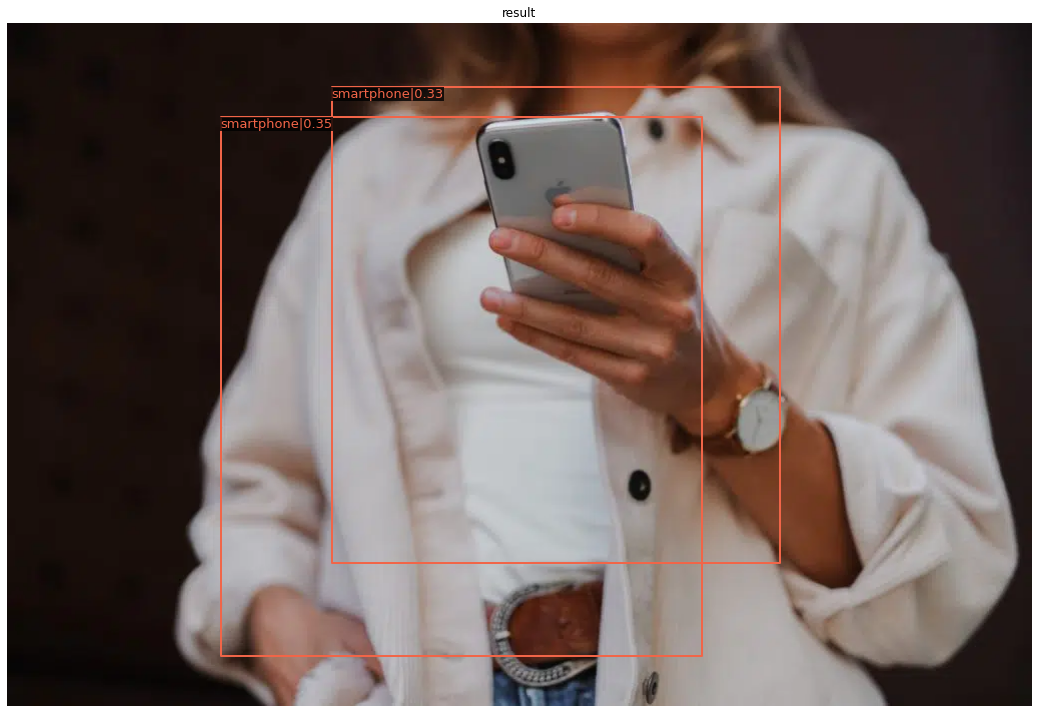

In [23]:
from mmdet.apis import inference_detector, show_result_pyplot

# Use the detector to do inference
img = '/home/aiteam/tykim/scratch/lightweight/mmcv_phone/hold_smartphone/imgs/a77.jpg'
result = inference_detector(model, img)
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)